Calculating R0 for Hungary and individual counties following the method used by Kevin Systrom as outlined in this [Python Notebook](https://github.com/k-sys/covid-19/blob/master/Realtime%20Rt%20mcmc.ipynb)

In [2]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import tarfile
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime
from datetime import timedelta

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load Hungary Country and County Data

In [3]:
county_names = ['Budapest',
            'Pest',
            'Baranya',
            'Békés',
            'Borsod-Abaúj-Zemplén',
            'Csongrád',
            'Fejér',
            'Heves',
            'Hajdú-Bihar',
            'Nógrád',
            'Jász-Nagykun-Szolnok',
            'Szabolcs-Szatmár-Bereg',
            'Bács-Kiskun',
            'Tolna',
            'Veszprém',
            'Somogy',
            'Komárom-Esztergom',
            'Győr-Moson-Sopron',
            'Vas',
            'Zala']

url = 'https://raw.githubusercontent.com/nickgon/Hungary-COVID19-Data/master/Hungary_COVID19_data_by_county.csv'

counties = pd.read_csv(url,
                     parse_dates=['Date'])

# Add the total cases in Hungary for country level analysis
counties['Hungary'] = counties.loc[:, county_names].sum(1)

county_names.append('Hungary')

counties = pd.melt(counties, 
                   id_vars=['Date'],
                   value_vars= county_names,
                   var_name='County',
                   value_name='Cases')
counties = counties.set_index(['County', 'Date']).sort_index()

counties

Cases
County  Date             
Baranya 2020-04-01     19
        2020-04-02     19
        2020-04-03     21
        2020-04-04     21
        2020-04-05     23
        2020-04-06     23
        2020-04-07     23
        2020-04-08     23
        2020-04-09     23
        2020-04-10     28
        2020-04-11     29
        2020-04-12     29
        2020-04-13     29
        2020-04-14     29
        2020-04-15     29
        2020-04-16     32
        2020-04-17     33
        2020-04-18     33
        2020-04-19     33
        2020-04-20     33
        2020-04-21     34
        2020-04-22     35
        2020-04-23     33
        2020-04-24     33
        2020-04-25     33
        2020-04-26     33
        2020-04-27     33
        2020-04-28     33
        2020-04-29     34
        2020-04-30     34
...                   ...
Zala    2020-07-29    265
        2020-07-30    265
        2020-07-31    265
        2020-08-01    265
        2020-08-02    265
        2020-08-03    265
        2020-08-04    265
        2020-08-05    265
        2020-08-06    265
        2020-08-07    265
        2020-08-08    265
        2020-08-09    265
        2020-08-10    265
        2020-08-11    265
        2020-08-12    265
        2020-08-13    266
        2020-08-14    266
        2020-08-15    266
        2020-08-16    277
        2020-08-17    277
        2020-08-18    277
        2020-08-19    279
        2020-08-20    279
        2020-08-21    279
        2020-08-22    279
        2020-08-23    279
        2020-08-24    279
        2020-08-25    279
        2020-08-26    279
        2020-08-27    279

[3129 rows x 1 columns]

#### Integrity Check

In [4]:
# Make sure that all the states have current data
today = datetime.combine(date.today(), datetime.min.time())
last_updated = counties.reset_index('Date').groupby('County')['Date'].max()
is_current = last_updated < today

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all counties have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for county, grp in counties.groupby('County'):
    new_cases = grp.Cases.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {county} has date with negative case counts")
        display(new_cases[~is_positive])
        print('===================================')
        
# Let's make sure that counties have added cases
idx = pd.IndexSlice

yesterday = datetime.strftime(today - timedelta(1), '%Y-%m-%d')

try:
    assert not counties.loc[idx[:, yesterday:today.strftime('%Y-%m-%d')], 'Cases'].groupby('County').diff().dropna().eq(0).any()

except AssertionError:
        print('Some counties have had no new cases')

County   Date      
Baranya  2020-04-23   -2.0
         2020-06-11   -1.0
Name: Cases, dtype: float64

County                Date      
Borsod-Abaúj-Zemplén  2020-05-09   -2.0
                      2020-05-22   -3.0
Name: Cases, dtype: float64

County    Date      
Budapest  2020-06-16   -5.0
Name: Cases, dtype: float64

County       Date      
Bács-Kiskun  2020-06-11   -4.0
             2020-06-16   -1.0
             2020-08-25   -1.0
Name: Cases, dtype: float64

County  Date      
Békés   2020-05-12   -1.0
        2020-05-13   -5.0
        2020-07-21   -1.0
Name: Cases, dtype: float64

County    Date      
Csongrád  2020-06-18   -1.0
          2020-06-25   -5.0
Name: Cases, dtype: float64

County  Date      
Fejér   2020-08-01   -1.0
Name: Cases, dtype: float64

County             Date      
Győr-Moson-Sopron  2020-04-23   -3.0
Name: Cases, dtype: float64

County       Date      
Hajdú-Bihar  2020-04-23   -1.0
             2020-06-27   -6.0
             2020-07-18   -1.0
             2020-08-15   -4.0
Name: Cases, dtype: float64

County  Date      
Heves   2020-05-09   -1.0
        2020-05-20   -4.0
        2020-06-03   -1.0
        2020-07-30   -1.0
Name: Cases, dtype: float64

County   Date      
Hungary  2020-06-16   -12.0
Name: Cases, dtype: float64

County                Date      
Jász-Nagykun-Szolnok  2020-04-04   -1.0
                      2020-05-28   -9.0
                      2020-06-06   -1.0
                      2020-07-04   -2.0
                      2020-08-26   -2.0
Name: Cases, dtype: float64

County             Date      
Komárom-Esztergom  2020-04-04   -1.0
                   2020-05-27   -1.0
                   2020-06-16   -2.0
Name: Cases, dtype: float64

County  Date      
Nógrád  2020-06-12   -3.0
        2020-07-31   -1.0
Name: Cases, dtype: float64

County  Date      
Pest    2020-04-13   -1.0
        2020-06-16   -4.0
Name: Cases, dtype: float64

County  Date      
Somogy  2020-06-06   -7.0
Name: Cases, dtype: float64

County                  Date      
Szabolcs-Szatmár-Bereg  2020-04-22    -1.0
                        2020-05-22   -11.0
                        2020-05-28    -1.0
                        2020-08-26    -4.0
Name: Cases, dtype: float64

County  Date      
Tolna   2020-06-10   -3.0
        2020-06-13   -1.0
        2020-07-04   -1.0
        2020-08-08   -1.0
Name: Cases, dtype: float64

County  Date      
Vas     2020-04-23   -1.0
Name: Cases, dtype: float64

County    Date      
Veszprém  2020-06-12   -1.0
          2020-06-13   -3.0
Name: Cases, dtype: float64

County  Date      
Zala    2020-06-20   -1.0
        2020-07-20   -1.0
Name: Cases, dtype: float64

Some counties have had no new cases


Some counties have days with negative cases added. This should not be possible. Perhaps total counts go down because of misattribution to a county discovered at a later date. However, we will assume that they are a mistake. To correct for this, we will ignore these reductions and create new daily totals.

In [5]:
# We recalculate the daily total by calculating the diff and then replacing the first date with the starting value
# We then ignore all negative daily changes by setting them to 0
# Then the counties df is updated with cummulative sum to get the daily total for each county
for county, grp in counties.groupby('County'):
    new_cases = grp.Cases.diff().fillna(grp.Cases[0])
    new_cases[new_cases < 0] = 0
    adj_cases = np.cumsum(new_cases)
    counties.update(adj_cases)
    


In [6]:
# Add the total cases in Hungary for country level analysis
#counties['Hungary'] = counties.loc[:, county_names].sum(1)

#county_names.append('Hungary')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    # Because we adjusted the county case counts by removing negative case changes, 
    # we need to update the country total to get the adjusted case count for all of
    # Hungary
    # Here we sum across 'Date' and call it Hungary. Then reorder the index to match 
    # the order of our existing MultiIndex dataframe
    hungary = counties.iloc[counties.index.get_level_values(0) != 'Hungary'].sum(level=['Date']) \
        .assign(County='Hungary_Adj') \
        .set_index('County', append=True) \
        .reorder_levels([1,0])
    # Now we concatenate the total hungary data to the county data and sort it for good measure
    counties = pd.concat([counties,hungary]).sort_index()

In [7]:
counties.iloc[counties.index.get_level_values(0) != 'Hungary']

Cases
County  Date             
Baranya 2020-04-01   19.0
        2020-04-02   19.0
        2020-04-03   21.0
        2020-04-04   21.0
        2020-04-05   23.0
        2020-04-06   23.0
        2020-04-07   23.0
        2020-04-08   23.0
        2020-04-09   23.0
        2020-04-10   28.0
        2020-04-11   29.0
        2020-04-12   29.0
        2020-04-13   29.0
        2020-04-14   29.0
        2020-04-15   29.0
        2020-04-16   32.0
        2020-04-17   33.0
        2020-04-18   33.0
        2020-04-19   33.0
        2020-04-20   33.0
        2020-04-21   34.0
        2020-04-22   35.0
        2020-04-23   35.0
        2020-04-24   35.0
        2020-04-25   35.0
        2020-04-26   35.0
        2020-04-27   35.0
        2020-04-28   35.0
        2020-04-29   36.0
        2020-04-30   36.0
...                   ...
Zala    2020-07-29  267.0
        2020-07-30  267.0
        2020-07-31  267.0
        2020-08-01  267.0
        2020-08-02  267.0
        2020-08-03  267.0
        2020-08-04  267.0
        2020-08-05  267.0
        2020-08-06  267.0
        2020-08-07  267.0
        2020-08-08  267.0
        2020-08-09  267.0
        2020-08-10  267.0
        2020-08-11  267.0
        2020-08-12  267.0
        2020-08-13  268.0
        2020-08-14  268.0
        2020-08-15  268.0
        2020-08-16  279.0
        2020-08-17  279.0
        2020-08-18  279.0
        2020-08-19  281.0
        2020-08-20  281.0
        2020-08-21  281.0
        2020-08-22  281.0
        2020-08-23  281.0
        2020-08-24  281.0
        2020-08-25  281.0
        2020-08-26  281.0
        2020-08-27  281.0

[3129 rows x 1 columns]

In [8]:
# Confirm the update
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(counties.loc[['Hungary','Hungary_Adj']])

                         Cases
County      Date              
Hungary     2020-04-01   525.0
            2020-04-02   585.0
            2020-04-03   623.0
            2020-04-04   678.0
            2020-04-05   733.0
            2020-04-06   744.0
            2020-04-07   817.0
            2020-04-08   895.0
            2020-04-09   980.0
            2020-04-10  1190.0
            2020-04-11  1310.0
            2020-04-12  1410.0
            2020-04-13  1458.0
            2020-04-14  1512.0
            2020-04-15  1579.0
            2020-04-16  1652.0
            2020-04-17  1763.0
            2020-04-18  1834.0
            2020-04-19  1916.0
            2020-04-20  1984.0
            2020-04-21  2098.0
            2020-04-22  2168.0
            2020-04-23  2284.0
            2020-04-24  2383.0
            2020-04-25  2443.0
            2020-04-26  2500.0
            2020-04-27  2583.0
            2020-04-28  2649.0
            2020-04-29  2727.0
            2020-04-30  2775.0
        

## Load Patient Information

In [9]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename

# The data was moved since this analysis was last conducted
URL = "https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz?raw=true"
LINELIST_PATH = 'data/latestdata.tar.gz'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


In [10]:
if not os.path.exists('data/latestdata.csv'):
    tar = tarfile.open(LINELIST_PATH)
    tar.extractall(path='data/')
    tar.close()
    print('unzipped')
else:
    print('Patient Data Already Unzipped')

Patient Data Already Unzipped


### Parse & Clean Patient Info

In [11]:
patients = pd.read_csv(
    'data/latestdata.csv',
    parse_dates=True,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

patients["Onset"].iloc[0]

Timestamp('2020-02-08 00:00:00')

#### Show Relationship between Onset of Symptoms and Confirmation

To estimate the 'real' spread of the virus, we can't just look at confirmed cases, but need to estimate when they first occurred. This chart is meant to show the delay between when a case was confirmed and the onset. If we know the distribution of onset to confirmed delays, we can then reverse engineer our confirmed case data back to when the cases were initially contracted.

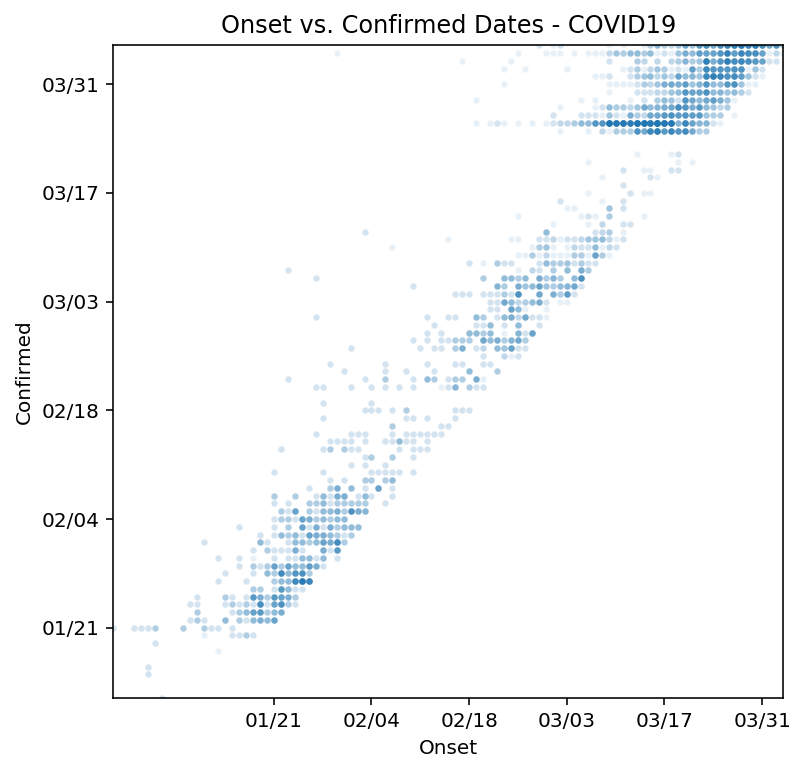

In [12]:
# Plotting scatter from pandas resulted in an error. This method uses pyplot.
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(patients['Onset'], 
           patients['Confirmed'],  
           alpha=0.1, 
           lw=0,
           s=10)

ax.set_title('Onset vs. Confirmed Dates - COVID19')
ax.set_xlabel('Onset')
ax.set_ylabel('Confirmed')

ax.set_xlim(min(patients['Onset']), max(patients['Onset']))
ax.set_ylim(min(patients['Confirmed']), max(patients['Confirmed']))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

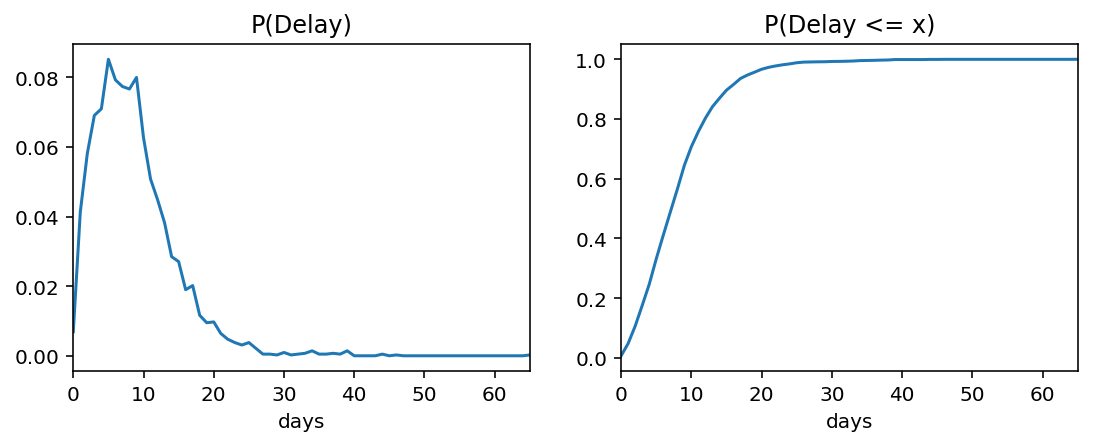

In [13]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

### A Single County

#### Select County Data

In [14]:
county = 'Hungary'
confirmed = counties.xs(county).Cases.diff().dropna()
confirmed.tail()

Date
2020-08-23    22.0
2020-08-24    36.0
2020-08-25    24.0
2020-08-26    73.0
2020-08-27    91.0
Name: Cases, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [15]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset


onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [16]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1,
        mode='constant')
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

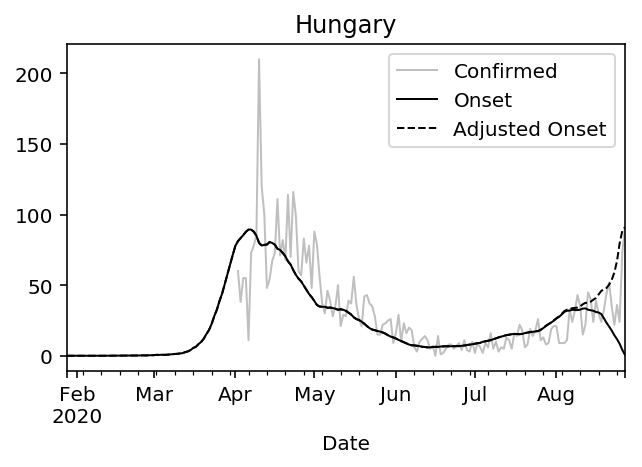

In [17]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=county,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3
We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$
We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in onset cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [18]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [19]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, county):
    confirmed = county.Cases.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [20]:
models = {}

for county, grp in counties.groupby('County'):
    
    print(county)
    
    if county in models:
        print(f'Skipping {county}, already in cache')
        continue
    
    models[county] = create_and_run_model(county, grp.droplevel(0))

Baranya


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 301.39it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Borsod-Abaúj-Zemplén


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 317.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Budapest


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 219.20it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Bács-Kiskun


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 310.20it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Békés


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 311.39it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Csongrád


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 319.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Fejér


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 315.57it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Győr-Moson-Sopron


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 307.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Hajdú-Bihar


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 313.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Heves


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 321.62it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Hungary


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:20<00:00, 192.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Hungary_Adj


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 221.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Jász-Nagykun-Szolnok


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 332.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Komárom-Esztergom


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 315.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Nógrád


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 337.96it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Pest


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 302.27it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Somogy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 328.98it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Szabolcs-Szatmár-Bereg


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 289.43it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tolna


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 318.94it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Vas


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 298.76it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Veszprém


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 291.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Zala


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 316.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Handle Divergences

In [21]:

# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for county, n_divergences in divergences[has_divergences].items():
    models[county].run()

Diverging states:


Series([], dtype: int64)

### Compile Results

In [22]:
results = None

for county, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

### Render to CSV

Uncomment if you'd like

In [23]:
results.to_csv('data/rt_.csv')

## Render Charts

In [24]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0, 2)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    last_value = round(result['median'].iloc[-1], 2)
    ax.annotate(last_value, 
                (result.index[-1], last_value),
                xytext=(-15, 10), 
                textcoords='offset points')
    ax.fill_between(
        result.index,
        result['lower_90'].values,
        result['upper_90'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

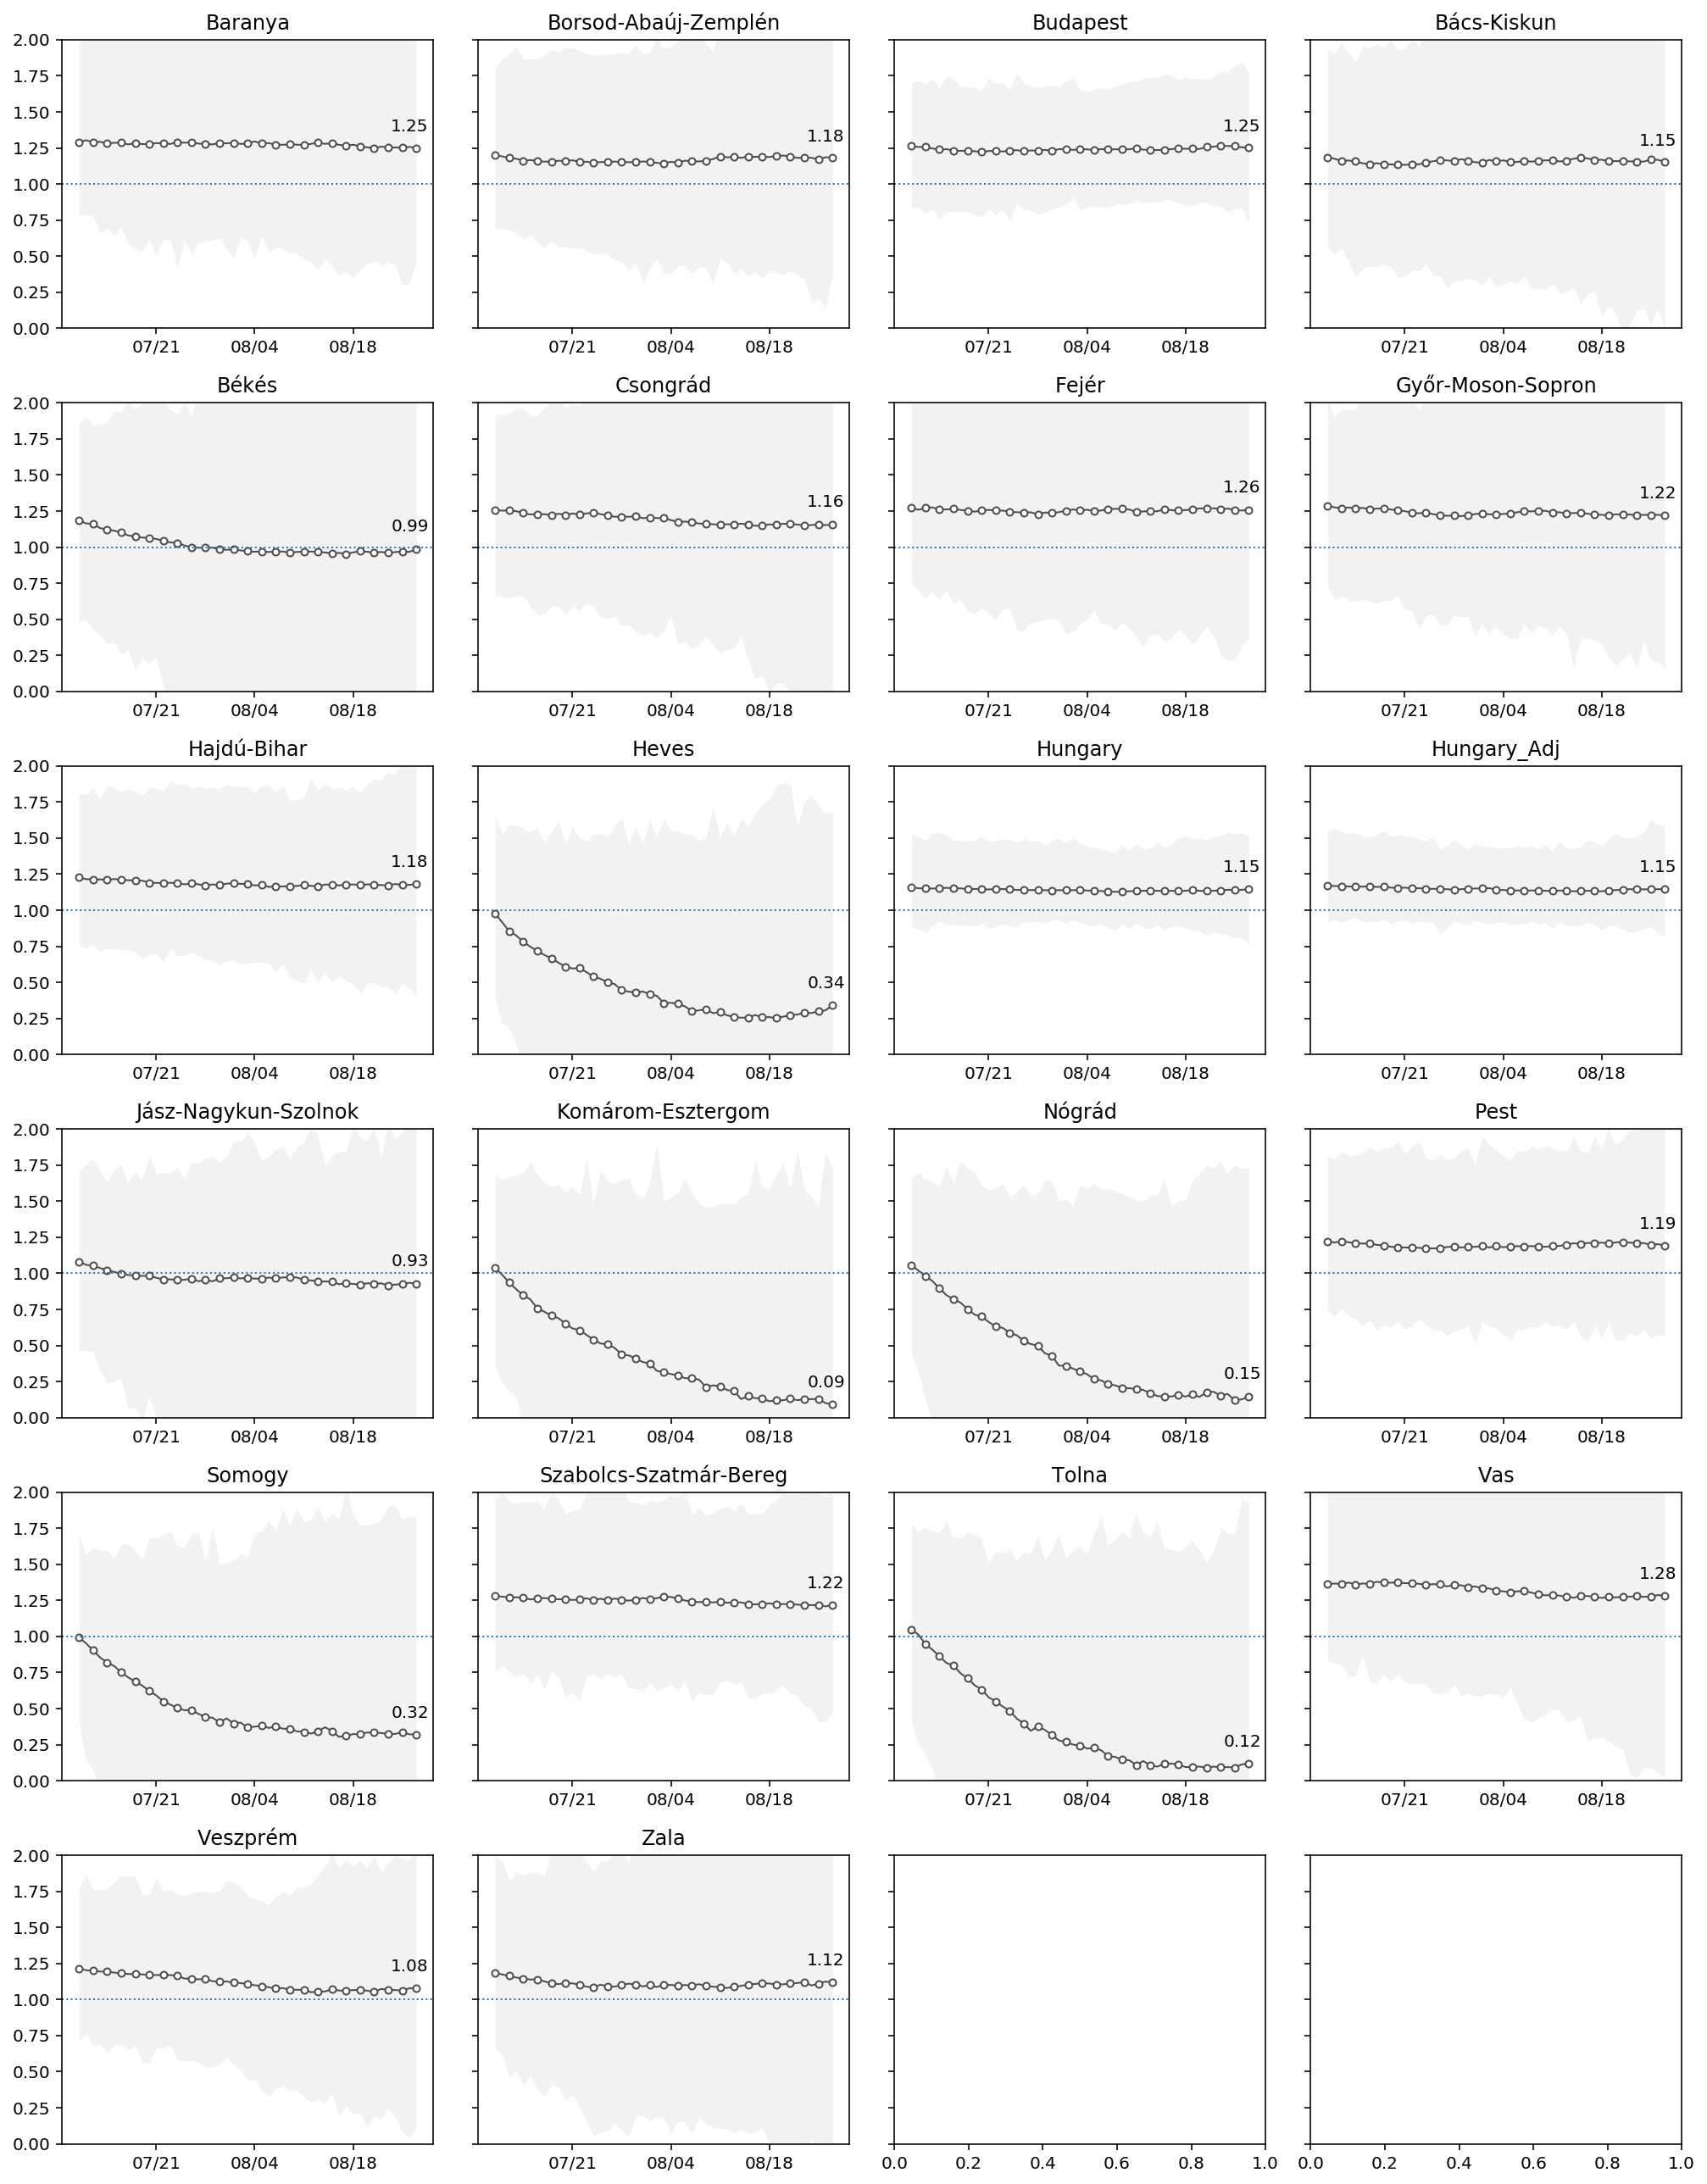

In [25]:
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (county, result) in zip(axes.flat, results.groupby('region')):
    #print(results.droplevel(0).index[-1])
    plot_rt(county, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')

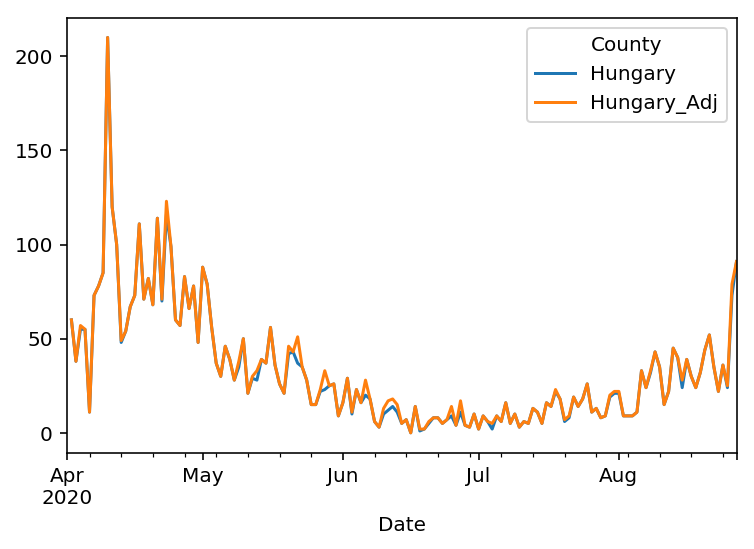

In [26]:
counties.Cases.unstack(level=1).loc[['Hungary','Hungary_Adj'],:].transpose().diff().plot()

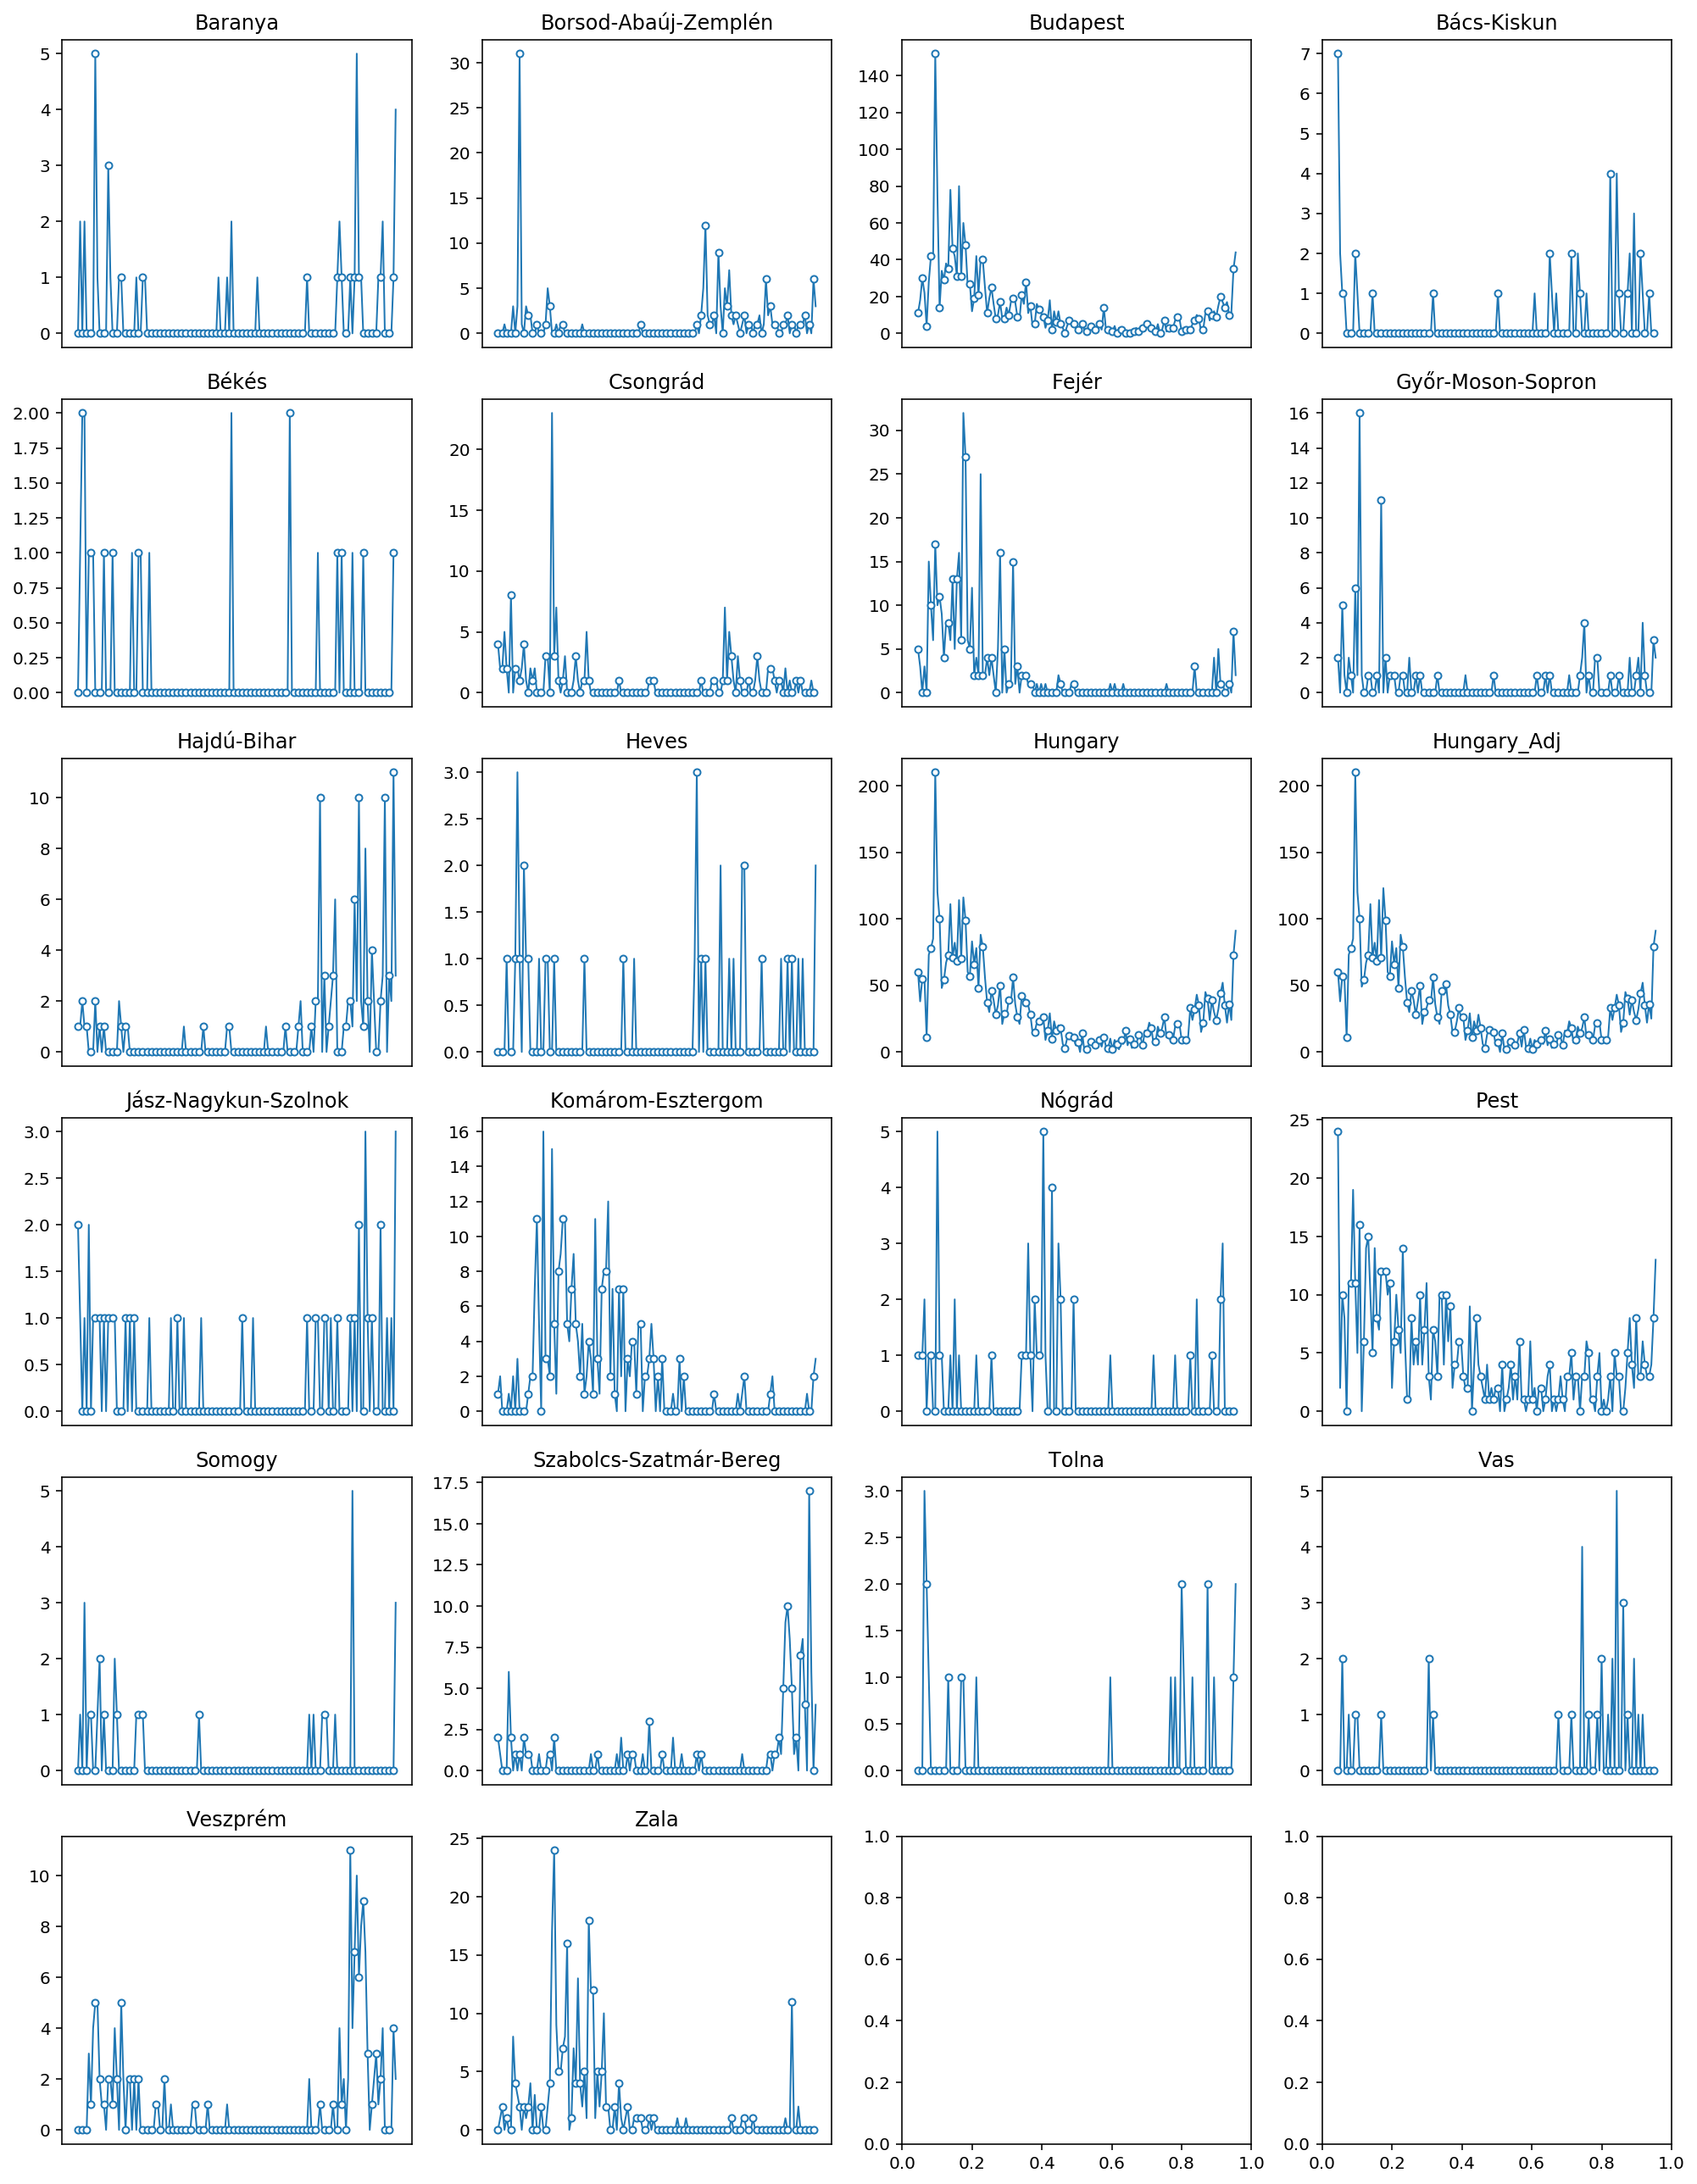

In [27]:
#Plotting daily new cases using adjusted case data from earlier
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

ncols = 4
nrows = int(np.ceil(counties.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3))

for ax, (county, grp) in zip(axes.flat, counties.groupby('County')):
    ax.set_title(county)
    ax.plot(grp.Cases.diff().dropna().values,
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            markevery=2)    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

fig.tight_layout()
fig.set_facecolor('w')